In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import string
import numpy as np
import os
import glob

import nltk
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

import wordcloud
from wordcloud import WordCloud, STOPWORDS
from textblob import Word
from collections import Counter

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
train_df = pd.read_csv("../Data/train_data.csv", encoding = "ISO-8859-1")
train_df.head()

,tweet_id,username,text,airline_name,tweet_location,airline_sentiment
0,5.801223e+08,WhaleAlamu,pay my refund. wakanow claimed they are expect...,British_Airways,NaN,Negative
1,5.677581e+17,roxydigital,@JetBlue @JayVig YES! Great real-time example....,Delta,"Charlotte, NC",Positive
2,5.692946e+17,jshieber,@USAirways hell is terrible gate agents. And a...,US Airways,New York,Negative
3,5.697036e+17,JesseSheriff,"@AmericanAir is the new @SpiritAirlines, and b...",American,West Palm Beach,Negative
4,2.188353e+08,Cmdr_Pants,"i was, the just called, she was very helpful.",SingaporeAir,"Brisbane, Australia",Neutral


In [8]:
stopwords_lstm = pd.read_csv('../Train_LSTM/stopwords_lstm.csv')

def preprocess(text):

    stopwords = set(STOPWORDS)

    # Appending new airline related stop-words
    stopwords.update([str(i).lower() for i in stopwords_lstm.name])

    # Filter for mentions
    mentions_filter = re.compile(r'(?<=\@)(\w+)')

    # Filter for hash-tags
    hashtags_filter = re.compile(r'(?<=\#)(\w+)')

    # Filter for flights numbers
    flight_numbers = re.compile(r'(flt\d*)')

    # Finding all mentions
    all_mentions = mentions_filter.findall(text.lower())

    # Finding all hash-tags
    all_hashtag = hashtags_filter.findall(text.lower())

    # Finding all hash-tags
    all_flights = flight_numbers.findall(text.lower())

    word_lemmatize = WordNetLemmatizer()

    # Lemmatizing
    def lemm_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(lemmatize.lemmatize(item,'v'))
        return lemmatized

    # De-emojify tweets to text
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')

    text = deEmojify(text)
    soup = BeautifulSoup(text)
    text = soup.get_text()

    # Removing punctuation
    punc_text = [x.lower() for x in text if x not in string.punctuation]
    text = "".join(punc_text)

    # Tokenize words
    word_tokens = nltk.word_tokenize(text)

    # Keeping the words with length between 2 and 15
    filtered_tokens = [x for x in word_tokens if len(x)>2 and len(x)<15]

    # Filter tokens
    tokens = lemm_tokens(filtered_tokens, word_lemmatize)
    all_tokens = [i for i in tokens if (i not in stopwords) and (i not in all_mentions)
                  and (i not in all_hashtag) and (i not in all_flights) and (not i.isdigit())]

    return all_tokens

In [9]:
train_df = train_df.dropna(subset=['text'])

In [10]:
train_df['text_tokenized']=train_df['text'].astype("string").map(preprocess)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14096\4259542227.py:42: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text)


In [11]:
train_df = train_df.reset_index(drop=True)

In [12]:
def remove_if_empty(df):
    empty_ids = df['text_tokenized'].map(lambda i: len(i)) > 0
    idsToDelete = []
    for i in range(len(empty_ids)):
        if not empty_ids[i]:
            idsToDelete.append(i)
    for currentID in idsToDelete:
        df = df.drop(df[df.index == currentID].index[0])
    return df

In [13]:
print(train_df.shape)
train_df = remove_if_empty(train_df)
print(train_df.shape)

(29708, 7)
(29645, 7)


In [14]:
lb=LabelEncoder()
train_df['airline_sentiment'] = lb.fit_transform(train_df['airline_sentiment'])

tokenizer = Tokenizer(num_words=2000, split=' ')
tokenizer.fit_on_texts(train_df['text_tokenized'].values)
X = tokenizer.texts_to_sequences(train_df['text'].values)
X = pad_sequences(X)

model = Sequential()
model.add(Embedding(2000, 128, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adamw', metrics = ['accuracy'])
print(model.summary())

#Splitting the data into training and testing
y=pd.get_dummies(train_df['airline_sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

batch_size=32
model.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test),batch_size=batch_size, verbose = 'auto')
model.evaluate(X_test,y_test)

e:\2024_2025_HK1\TLCN\telekafka\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
742/742 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.5825 - loss: 0.9292 - val_accuracy: 0.6698 - val_loss: 0.7535
Epoch 2/50
742/742 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.6908 - loss: 0.7104 - val_accuracy: 0.6971 - val_loss: 0.7096
Epoch 3/50
742/742 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.7275 - loss: 0.6526 - val_accuracy: 0.7062 - val_loss: 0.6899
Epoch 4/50
742/742 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.7479 - loss: 0.6078 - val_accuracy: 0.7254 - val_loss: 0.6683
Epoch 5/50
742/742 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.7711 - loss: 0.5626 - val_accuracy: 0.7295 - val_loss: 0.6662
Epoch 6/50
742/742 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.7832 - loss: 0.5284 - val_accuracy: 0.7431 - val_loss: 0.6370
Epoch 7/50
742/742 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - accuracy: 0.8048 - loss: 0.4796 - val_accuracy: 0.7448 - val_loss: 0.6559
Epoch 8/50
742/742 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.8180 - loss: 0.45

[1.04254949092865, 0.7947377562522888]

In [15]:
from pathlib import Path

model_structure = model.to_json()
f = Path("../Train_LSTM/model_structure_new.json")
f.write_text(model_structure)

# Đổi tên tệp lưu trọng số mô hình
model.save_weights("../Train_LSTM/model_weights_new.weights.h5")

model.save('../Train_LSTM/model_new.h5')

max_length = str(len(X_train[0]))
f = Path("../Train_LSTM/X_train_max_length_new.txt")
f.write_text(max_length)

train_df = train_df.reset_index(drop=True)
train_df[['text_tokenized']].to_csv("../Train_LSTM/train_text_vals_new.csv")


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


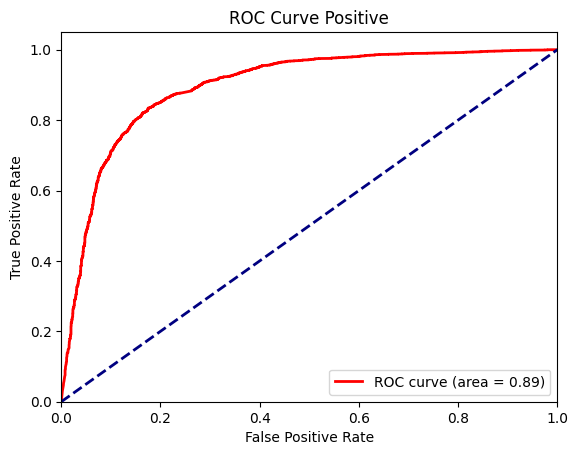

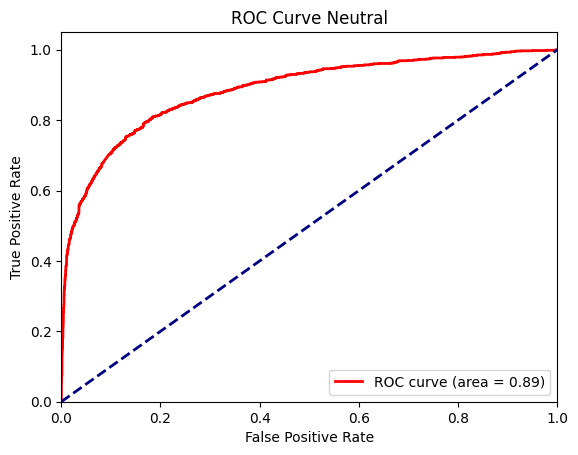

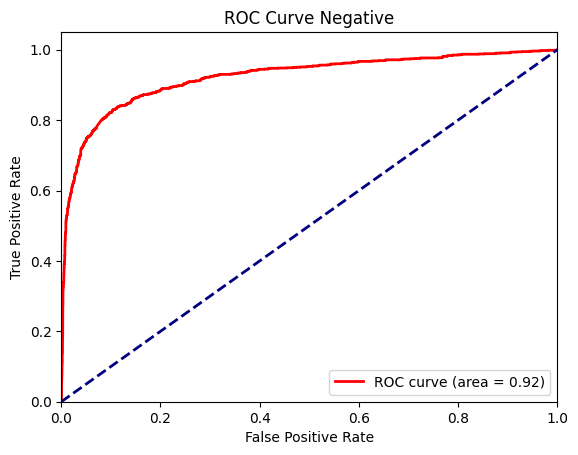

In [16]:
# ROC Curve Plotting
from sklearn.metrics import roc_curve, auc

fpr, tpr, roc_auc = {}, {}, {}

y_test = y_test.to_numpy()
y_score = model.predict(X_test)

label = ['Positive','Neutral','Negative']
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for nc in range(3):
    plt.figure()
    plt.plot( fpr[nc], tpr[nc],
        color="red", lw=2, label="ROC curve (area = %0.2f)" % roc_auc[nc])
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve "+label[nc])
    plt.legend(loc="lower right")
    plt.show()